#  Tabular Classification (Fiverr Portfolio Demo)
Developed by **AıdepthLab**
PhD-level Deep Learning Researcher | AI Engineer | Data Scientist

###  Project Description
This notebook demonstrates a **PhD-level end-to-end AI workflow** for tabular data classification —  covering every step from preprocessing and model training to explainable AI (XAI) and web deployment.
It is conceptually inspired by my doctoral research on **Deep Learning–based classification using CT-derived structured measurements**, adapted here into a generalizable **tabular classification framework** suitable for real-world predictive analytics.
The project is designed to demonstrate **clean, reproducible, and fully open-source machine learning workflows using free tools and frameworks.

##  **Project Overview**
- **Goal:** Predict categorical outcomes (e.g., cancer diagnosis) from structured numerical data  
- **Dataset Example:** Breast Cancer Wisconsin Dataset (scikit-learn)  
- **Pipeline:**  
  - Data preprocessing (`StandardScaler`)  
  - Model training (`LogisticRegression`, `RandomForest`, `MLPClassifier`)  
  - Evaluation (`Classification Report`, `Confusion Matrix`, `ROC Curve`, `Learning Curve`)  
  - Explainability (`SHAP`, feature importance)  
  - Deployment (Streamlit app for live prediction and model visualization)

##  **Key Features**
| Module | Description |
| `data_loader.py` | Loads and prepares structured tabular data |
| `visualization.py` | Generates confusion matrix, ROC curve, and learning curve |
| `xai_explainer.py` | Creates SHAP-based explainability and fallback feature plots |
| `utils.py` | Handles model saving, JSON export, and directory management |
| `app/streamlit_app.py` | Interactive web demo (upload CSV, view predictions, explanations, and metrics) |

##  **Explainable AI (XAI)**
- SHAP summary plot reveals **which features most influence predictions**  
- Automatically detects model type (Tree / Linear / Neural / Pipeline)  
- Includes **fallback bar charts** if SHAP is not supported  
- All visuals are saved under `/figures/`

## **Technology Stack**
**Programming Language:**  
- Python (3.12)

**Machine Learning Libraries:**  
- scikit-learn  
- XGBoost *(optional)*  
- SHAP  
- NumPy  
- Pandas  

**Visualization:**  
- Matplotlib  
- Plotly  

**Deployment:**  
- Streamlit  
- Joblib  
- Jupyter Notebook  

##  **Demo Interface (Streamlit)**

The web app includes three sections:  
1-  **Upload & Predict** – upload your own CSV file to get predictions  
2- **Model Explanation** – view SHAP or feature-importance visualizations  
3- **Model Performance** – review evaluation plots (Confusion Matrix, ROC, Learning Curve)

Run locally:
```bash
cd tabular_classification_demo/app
streamlit run streamlit_app.py

### Objectives
- Perform supervised classification on structured tabular data  
- Evaluate models using standard ML metrics and visual diagnostics  
- Generate explainability plots (SHAP, feature importances)  
- Save trained artifacts for deployment and reproducibility  
- Deploy an interactive web demo via Streamlit

###  Notebook Contents
1- Data Loading and Preprocessing  
2- Model Training and Evaluation  
3- Performance Visualization (Confusion Matrix, ROC, Learning Curve)  
4- Explainable AI (SHAP Summary & Feature Importances)  
5- Model Saving (`artifacts/`) and Visualization (`figures/`)  
6- Optional Web Deployment via `app/streamlit_app.py`

> 🧭 *This notebook serves as an open-source demonstration of explainable tabular AI combining academic rigor with practical deployment readiness.*


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from utils import ensure_dir, save_json, save_model
from data_loader import load_breast_cancer_data
from visualization import plot_confusion_matrix, plot_roc_curve, plot_learning_curve
from xai_explainer import shap_summary_plot


In [2]:
X, y = load_breast_cancer_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(" Data loaded successfully.")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

 Data loaded successfully.
Train shape: (455, 30) Test shape: (114, 30)


In [3]:
from model_training import train_with_cv

# Logistic Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
param_lr = {"clf__C": [0.1, 1, 10]}

# Random Forest
pipe_rf = Pipeline([
    ("clf", RandomForestClassifier(random_state=42))
])
param_rf = {"clf__n_estimators": [200, 400],
            "clf__max_depth": [None, 8, 12]}

# MLP
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(random_state=42, max_iter=1000))
])
param_mlp = {"clf__hidden_layer_sizes": [(64,), (128,), (64, 32)]}

In [4]:
grids = []
for name, pipe, params in [("LR", pipe_lr, param_lr), ("RF", pipe_rf, param_rf), ("MLP", pipe_mlp, param_mlp)]:
    grid = train_with_cv(pipe, params, X_train, y_train)
    grids.append((name, grid))
    print(f" {name} best score: {grid.best_score_:.3f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 LR best score: 0.986
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 RF best score: 0.970
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 MLP best score: 0.981


In [5]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
fig_dir = os.path.join(base_dir, "figures")
art_dir = os.path.join(base_dir, "artifacts")

In [6]:
best = max(grids, key=lambda t: t[1].best_score_)[1]
best_model = best.best_estimator_
print("🏆 Best model:", best_model)

save_model(best_model, art_dir + "/best_model.pkl")
print(" Model saved to artifacts/best_model.pkl")

🏆 Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=0.1, max_iter=1000))])
 Model saved to artifacts/best_model.pkl


In [7]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
save_json(report, art_dir + "/metrics.json")

print("Classification report saved.")
print(pd.DataFrame(report).T.head())

Classification report saved.
              precision    recall  f1-score     support
0              0.975610  0.952381  0.963855   42.000000
1              0.972603  0.986111  0.979310   72.000000
accuracy       0.973684  0.973684  0.973684    0.973684
macro avg      0.974106  0.969246  0.971583  114.000000
weighted avg   0.973711  0.973684  0.973616  114.000000


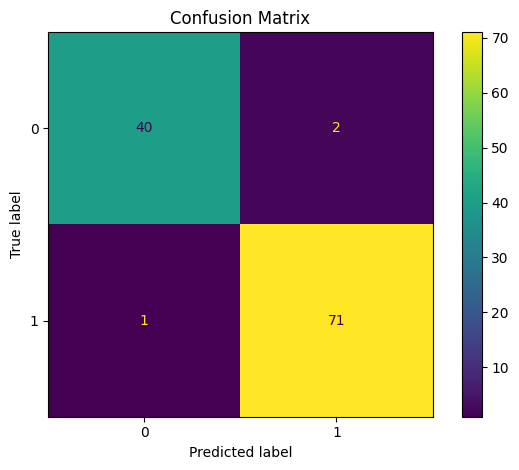

✅ Confusion matrix saved: /home/yakamoz/tabular_classification_demo/figures/confusion_matrix.png


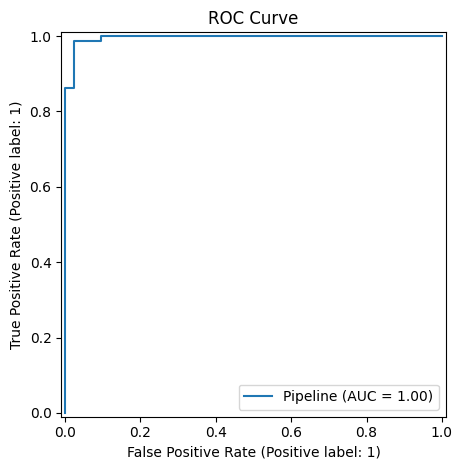

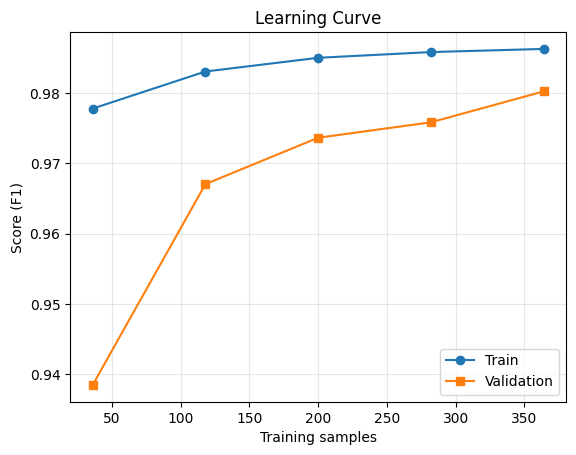

🔍 Starting SHAP analysis...
Model type: Pipeline
🧩 Detected Pipeline. Extracting final estimator...
➡️ Inner model: LogisticRegression
📈 Using LinearExplainer
📊 Generating SHAP summary plot...


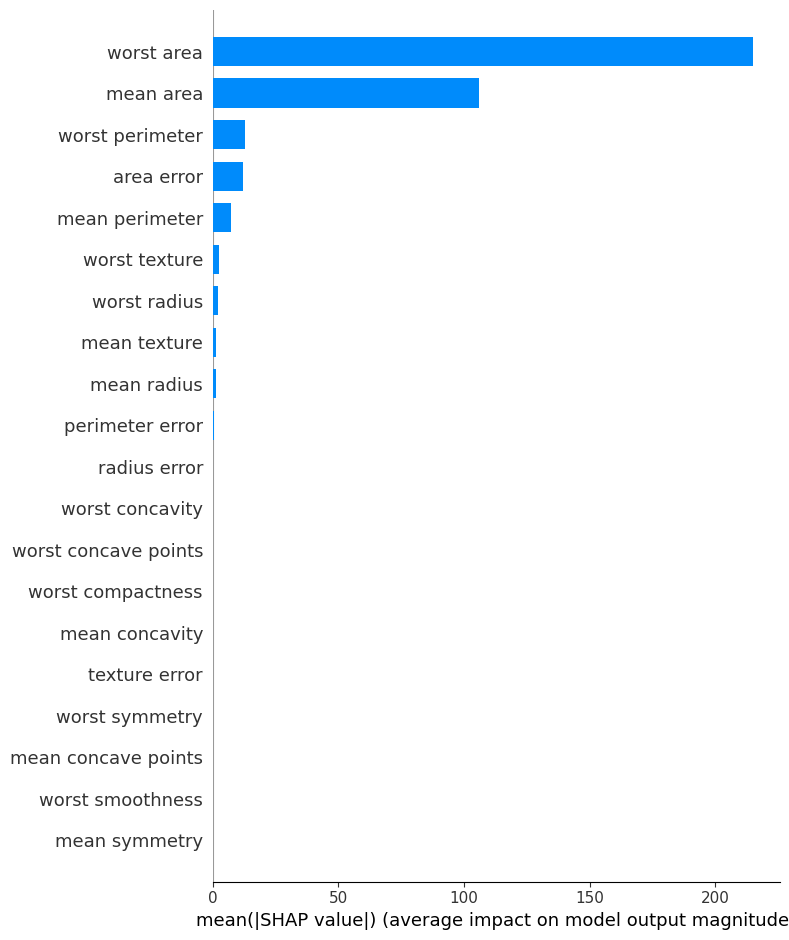

✅ SHAP summary plot saved: /home/yakamoz/tabular_classification_demo/figures/shap_summary.png


In [8]:
plot_confusion_matrix(y_test, y_pred, os.path.join(fig_dir, "confusion_matrix.png"), show=True)
plot_roc_curve(best_model, X_test, y_test, os.path.join(fig_dir, "roc_curve.png"), show=True)
plot_learning_curve(best_model, X_train, y_train, os.path.join(fig_dir, "learning_curve.png"), show=True)
shap_summary_plot(best_model, X_test, os.path.join(fig_dir, "shap_summary.png"), show=True)